In [1]:
import cbpro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from time import sleep, time
import ta
from datetime import datetime, timedelta
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

In [2]:
import json

#dicto = {"api_public": 
#         ,"api_secret": "
#         ,"passphrase": }
#with open("config_trading_bot.json", "w") as f:
#    f.write(json.dumps(dicto))

with open("config_trading_bot.json") as json_data_file:
    config = json.load(json_data_file)
client = cbpro.AuthenticatedClient(config["api_public"], config["api_secret"], config["passphrase"])

## Utility functions

In [3]:
def get_n_orders(client):
    counter = 0
    for e in client.get_orders():
        counter +=1
    return counter
    

In [4]:
def get_balance(client):
    for account in client.get_accounts():
        if account["currency"] == "EUR":
            balance = account["balance"]
            break

## DATA RETRIEVAL AND CLEANING


In [5]:
def getminutedata(symbol, interval_min=1, lookback=24*60):
    '''
    Method to obtain minute data from the Coinbase Pro API
    
    Parameters
    ----------
    
    symbol : str
         Symbol of the currency, e.g., "BTC-EUR", "DOT-EUR", "BTC-USD", "DOT-USD"
    
    interval_min : int
            The interval in minutes between the retrieved timestamps, can only be in the following range [1, 5, 15, 60, 360, 1440]
    
    lookback : int
        The number of minutes to lookback starting from the current timestamp
        
    Returns
    -------
    Pandas Dataframe
        a dataframe with the trade data

    '''
    
    MAX_REQUESTS = 300  # can only request 300 timestamps each time
    interval_sec = interval_min*60  # interval in seconds
    
    end = pd.to_datetime(client.get_time()["epoch"], unit ="s")  # end date
    start = end - timedelta(minutes=lookback)  # start date
    current_start = start
    
    try:
        # one request can only retrieve up to 300 timestamps: use for loop to obtain the desired range with multiple requests
        dataframes = []
        n_timestamps = int(lookback/interval_min)
        delta = timedelta(minutes=min(lookback, MAX_REQUESTS)*interval_min)  # time between each timestamp
        for i in range(int(n_timestamps/MAX_REQUESTS)):    
            current_end = current_start + delta
            dataframes.append(pd.DataFrame(client.get_product_historic_rates(symbol, current_start.isoformat(), current_end.isoformat(), interval_sec))[::-1])
            current_start = current_end
        dataframes.append(pd.DataFrame(client.get_product_historic_rates(symbol, current_start.isoformat(), end, interval_sec))[::-1])
        df = pd.concat(dataframes)
    except:
        print("ERROR:")
        print(client.get_product_historic_rates(symbol, current_start.isoformat(), current_end.isoformat(), interval_sec))  # should print what error we got
        
    # clean dataframe
    df.columns = ["Time", "Low", "High", "Open", "Close", "Volume"]
    df = df.astype(float)
    df = df.set_index("Time")
    df.index = pd.to_datetime(df.index, unit ="s")
    
    # add some measures
    df['RSI'] = ta.momentum.rsi(df.Close, window=10)
    df['SMA200'] = ta.trend.sma_indicator(df.Close, window=200)
    df['EMA200'] = ta.trend.ema_indicator(df.Close, window=200)
    df['SMA100'] = ta.trend.sma_indicator(df.Close, window=100)
    df['EMA100'] = ta.trend.ema_indicator(df.Close, window=100)
    df['SMA50'] = ta.trend.sma_indicator(df.Close, window=50)
    df['EMA50'] = ta.trend.ema_indicator(df.Close, window=50)
    df['SMA60'] = ta.trend.sma_indicator(df.Close, window=60)
    df['EMA60'] = ta.trend.ema_indicator(df.Close, window=60)

    df["pct change"] =df.Open.pct_change()+1
    df["CUM_RETURNS_50"] = (df.Open.pct_change()+1).rolling(50).apply(np.prod)
    df["CUM_RETURNS_60"] = (df.Open.pct_change()+1).rolling(60).apply(np.prod)
    df["CUM_RETURNS_100"] = (df.Open.pct_change()+1).rolling(100).apply(np.prod)

    return df

    
    

## Strategies

The function for each strategy should be able to take a **pandas dataframe** as input and returns **"BUY", "SELL", "NO TRADE"** to indicate whether and what kind of trade will happen.

In [6]:
def RSI_SMA_return_strategy(row, entried = False, max_profit=1.010, stop_loss=0.985):
    signal = (row.Close > row.SMA60) & (row.RSI < 40) & (row.CUM_RETURNS_60 < 1.03)  # RSI SMA strategy
    
    # not entried yet so try to buy
    if not entried:
        if signal:
            return "BUY" # buy next open
        
    # entried into a buy position so try to sell at a good price
    if entried:
        price_change_since_buying = row.Open/row.last_buying_price
        if row.RSI > 60:
            return "SELL" # sell next open
        elif price_change_since_buying > max_profit or price_change_since_buying < stop_loss:
            return "SELL"

    return "NO TRADE"  # No trade



In [7]:
def RSI_SMA_strategy(row, entried = False, stop_loss=0.985):
    signal = (row.Close > row.EMA50) & (row.RSI < 40)  # RSI SMA strategy
    
    # not entried yet so try to buy
    if not entried:
        if signal:
            return "BUY" # buy next open
        
    # entried into a buy position so try to sell at a good price
    if entried:
        price_change_since_buying = row.Open/row.last_buying_price
        if row.RSI > 50:
            return "SELL" # sell next open

        elif price_change_since_buying < stop_loss:
            return "SELL"

    return "NO TRADE"  # No trade

    

## Backtesting

In [8]:
def backtest(strategy, df, capital=1000):
    '''
    Backtest your strategy with this function
    
    Parameters
    ----------
    
    strategy : func
        function that returns "BUY", "SELL", "NO TRADE"
        
    df : pandas dataframe
        dataframe containing the trading data
    
    Returns
    -------
    Pandas dataframe
        dataframe containing the buying/selling dates with the profits, returns and open prices
    
    '''
    
    buying_dates = []
    buying_open_prices = []
    selling_dates = []
    selling_open_prices = []
    capital_list = [capital]
    crypto_list = []  # list of the number of crypto that is bought with the current capital
    entried = False
    
    # check per row whether we want to buy or sell the stock
    for i in range(len(df)-1):
        row = df.iloc[i].copy()
        next_row = df.iloc[i+1].copy()
        if entried:
            row["last_buying_price"] = buying_open_prices[-1]
        
        action = strategy(row, entried)
        timestamp = next_row.name
        
        if action == "BUY" and capital > 0 and entried == False:
            entried = True
            buying_dates.append(timestamp)
            buying_open_prices.append(next_row.Open)
            crypto_list.append(capital_list[-1]/next_row.Open)
        elif action == "SELL" and entried == True:
            entried = False
            selling_dates.append(timestamp)
            selling_open_prices.append(next_row.Open)
            capital_list.append(crypto_list[-1]*next_row.Open)
    
    # if we have more buying dates, then it means that the last selling date has not taken place yet
    if len(buying_dates) > len(selling_dates):
        buying_dates = buying_dates[:-1]
        buying_open_prices = buying_open_prices[:-1]
        
    actual_trades = pd.DataFrame({"buying_date": buying_dates, "selling_date": selling_dates, "buying_open_price": buying_open_prices, "selling_open_price": selling_open_prices})
    
    
        
    # plot results
    plt.style.use("ggplot")
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
    ax=axes[0,0]
    ax2=axes[1,0]
    ax3 = axes[0,1]
    
    #ax1
    df.plot(kind="line", y="Open", ax=ax, linewidth=0.7, alpha =0.5)
    #df.plot(kind="line", y="SMA200", c="orange", alpha =1, ax=ax, label = "SMA200")
    #df.plot(kind="line", y="EMA200", c="purple", alpha =1, ax=ax, label = "EMA200")
    #df.plot(kind="line", y="SMA50", alpha =1, ax=ax, label = "SMA50")
    #df.plot(kind="line", y="EMA100", alpha =1, ax=ax, label = "EMA100")
    #df.plot(kind="line", y="SMA100", alpha =1, ax=ax, label = "SMA100")
    #df.plot(kind="line", y="EMA50", alpha =1, ax=ax, label = "EMA50")
    
    df.plot(kind="line", y="SMA60", alpha =0.5, ax=ax, label = "SMA60")
    df.plot(kind="line", y="EMA60", c ="purple", alpha =0.5, ax=ax, label = "EMA60")
    actual_trades.plot(kind="scatter", s=20, c="red", x="buying_date", y="buying_open_price", ax=ax, label="BUY", alpha=1)
    actual_trades.plot(kind="scatter", s=20, c="green", x="selling_date", y="selling_open_price", ax=ax, label="SELL", alpha=1)
    ax.set_xlabel("time")
    ax.set_ylabel("price")
    #ax2
    df.plot(kind="line", y="RSI", linewidth=0.5, alpha =1, ax=ax2, label = "RSI")
    ax2.set_ylim((0,100))
    ax2.axhline(50, c="black")
    ax2.axhline(30, c="black")
    ax2.set_xlabel("time")
    #ax3
    df.plot(kind="line", y="pct change", c="orange", linewidth=0.7, alpha =1, ax=ax3, label = "pct change")
    #df.plot(kind="line", y="CUM_RETURNS_50", c="purple", linewidth=1, alpha = 0.7, ax=ax3, label = "CUM_RETURNS_50")
    df.plot(kind="line", y="CUM_RETURNS_60", c="green", linewidth=1, alpha = 0.7, ax=ax3, label = "CUM_RETURNS_60")
    ax3.set_xlabel("time")


    #myFmt = mdates.DateFormatter(' %H:%M:')

    #ax.xaxis.set_major_formatter(myFmt)



    plt.gcf().autofmt_xdate()
    
    # if there are actual trades retrieve the performance measures
    if len(actual_trades) > 0:
        # performance measures
        profits = df.loc[actual_trades.selling_date].Open.values - df.loc[actual_trades.buying_date].Open.values
        winning_rate = np.sum([profits>0])/len(profits)
        returns = (df.loc[actual_trades.selling_date].Open.values - df.loc[actual_trades.buying_date].Open.values)/df.loc[actual_trades.buying_date].Open.values

        # adding performance measures to dataframe
        actual_trades["profit"] = profits
        actual_trades["return"] = returns

        # print results
        print(capital_list)
        print(crypto_list)
        print("ACTUAL TRADES:")
        print(actual_trades)
        print("\n")
        print("profit: %.2f" % sum(profits)) 
        print("average returns:  %.6f" % (sum(returns)/max(1, len(returns))))
        print("returns:  %.6f" % (np.prod(returns+1)-1))
        print("winning rate:  %.2f" % (winning_rate))
        print("\n")
        print("starting capital: %.2f" % capital)
        print("end capital: %.2f" % capital_list[-1])
        print("return: %.6f" % ((capital_list[-1]-capital)/capital))
        return actual_trades
    else:

        print("NO TRADES HAVE TAKEN PLACE")
        return None

NO TRADES HAVE TAKEN PLACE


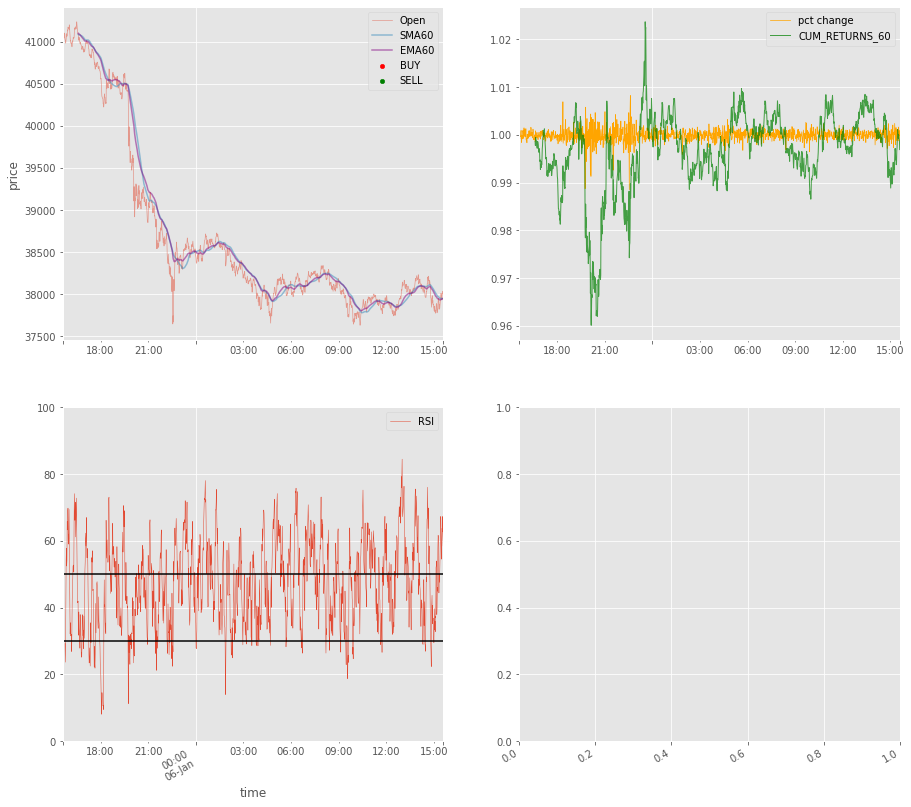

In [9]:
df = getminutedata("BTC-EUR", interval_min=1, lookback=60*24)
results = backtest(RSI_SMA_strategy, df)

[1000, 1000.6390980787038, 1002.367992948266, 1004.8133087732236, 1005.2242303923481, 1008.2188232134765, 1008.9126316908943]
[0.024704216416841163, 0.026278991785410027, 0.026240109721618363, 0.026493979311693627, 0.0264540001866459, 0.02646104032867233]
ACTUAL TRADES:
          buying_date        selling_date  buying_open_price  selling_open_price  profit    return
0 2022-01-05 19:02:00 2022-01-05 19:25:00           40478.92            40504.79   25.87  0.000639
1 2022-01-06 05:39:00 2022-01-06 05:58:00           38077.53            38143.32   65.79  0.001728
2 2022-01-06 07:37:00 2022-01-06 07:53:00           38199.84            38293.03   93.19  0.002440
3 2022-01-06 11:23:00 2022-01-06 11:55:00           37926.10            37941.61   15.51  0.000409
4 2022-01-06 13:27:00 2022-01-06 13:48:00           37998.95            38112.15  113.20  0.002979
5 2022-01-06 14:11:00 2022-01-06 14:35:00           38102.01            38128.23   26.22  0.000688


profit: 339.78
average returns:  0

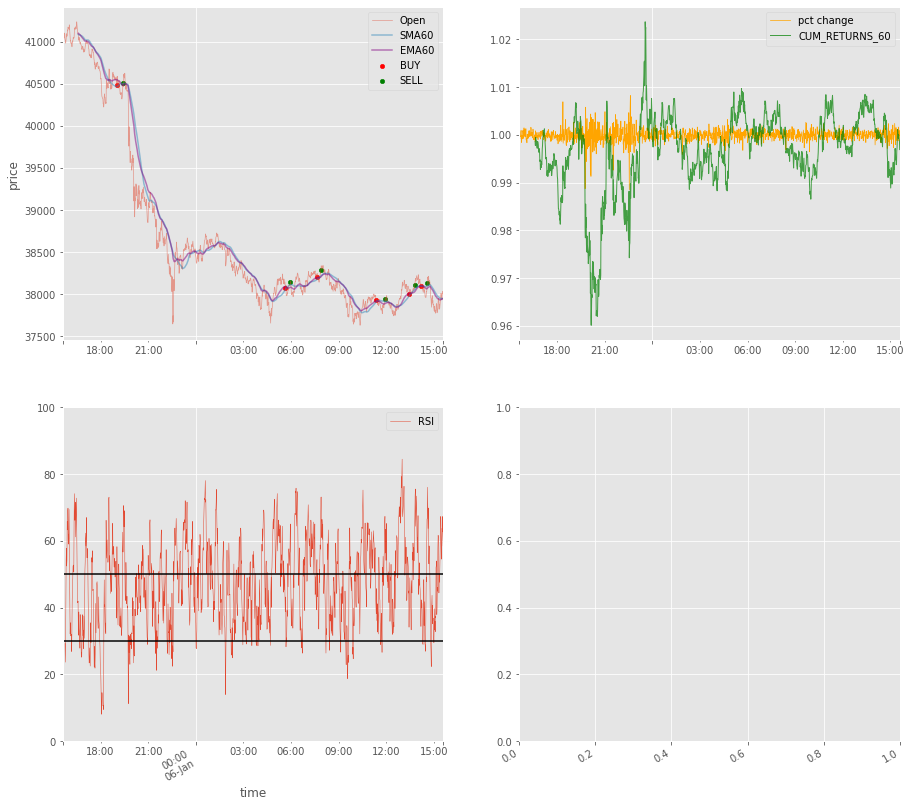

In [10]:
df = getminutedata("BTC-EUR", interval_min=1, lookback=60*24)
results = backtest(RSI_SMA_return_strategy, df)

In [11]:
row = df.iloc[-1,:]
buy_price = row.Open*0.995
buy_size = round(100/buy_price,7)
print(buy_size)

client.place_limit_order(product_id="BTC-EUR", side="buy", price=buy_price, size=buy_size)

0.0026415


{'message': 'price is too accurate. Smallest unit is 0.01000000'}

## TRADING BOT

In [12]:
def main(strategy, starting_capital, product_id="BTC-EUR", running_time = 60*2):
    '''
    Main to run the trading bot
    
    Parameters
    ----------
    
    strategy: func
         function that returns "BUY", "SELL", "NO TRADE"
    
    starting_capital: float
        the starting capital to start the trading bot
        
    product_id: str
        string of the currency you want to trade
    
    running_time: float
        amount of time you want to run the trading bot given in minutes
    
    Returns
    -------
    nothing yet
    
    '''
    start_time = time()
    entried = False
    buy_order = {"status": "done"}
    sell_order = {"status": "done"}
    capital = starting_capital
    
    while True:
        try:
            # check the running time
            if (time()-start_time)/60 < running_time:
                 
                
                df = getminutedata(product_id, interval_min=1, lookback=60*2)
                row = df.iloc[-1,:]
                action = strategy(row)
                print("Current time: %s Action: %s" % (str(pd.to_datetime(time(), unit="s")), action))
                # condition when we can buy
                if action == "BUY" and entried == False and buy_order["status"]=="done":
                    buy_price = round(row.Open*0.995, 6)
                    buy_size = round(capital/buy_price, 6)
                    buy_order = client.place_limit_order(product_id=product_id, side="buy", price=buy_price, size=buy_size)
                    entried = True
                    
                    # stats
                    print("Placed BUY order with the following details:")
                    print(buy_order)
                    print("\n")
                # condition when we can sell
                elif action == "SELL" and entried == True and sell_order["status"]=="done":
                    sell_price = round(row.Open, 6)
                    sell_size = round(buy_order["size"], 6)
                    sell_order = client.place_limit_order(product_id=product_id, side="sell", price=sell_price, size=sell_size)
                    entried=False
                    capital = get_balance(client) - 1 # minus 1 to ensure we have sufficient funds
                    
                    # stats
                    print("Placed SELL order with the following details:")
                    print(sell_order)
                    print("\n")
                
                sleep(63)
            else:
                print("Reached end of the allowed running time")
                print("Finished with: ")
                print(buy_order)
                print(sell_order)
                break
        except:
            print("An error had occured")
            sleep(63)
        
        

In [ ]:
main(RSI_SMA_return_strategy, starting_capital=100, running_time=60*10)

Current time: 2022-01-06 14:18:22.818074112 Action: NO TRADE
Current time: 2022-01-06 14:19:26.141518080 Action: NO TRADE
Current time: 2022-01-06 14:20:29.726443776 Action: NO TRADE
Current time: 2022-01-06 14:21:33.016373248 Action: NO TRADE
Current time: 2022-01-06 14:22:36.313927680 Action: NO TRADE
Current time: 2022-01-06 14:23:39.684242432 Action: NO TRADE
Current time: 2022-01-06 14:24:42.999876352 Action: NO TRADE
Current time: 2022-01-06 14:25:46.278503424 Action: NO TRADE
Current time: 2022-01-06 14:26:49.568848896 Action: NO TRADE
Current time: 2022-01-06 14:27:53.141028096 Action: NO TRADE
Current time: 2022-01-06 14:28:56.464663808 Action: NO TRADE
Current time: 2022-01-06 14:30:00.013943808 Action: NO TRADE
Current time: 2022-01-06 14:31:03.594124288 Action: NO TRADE
Current time: 2022-01-06 14:32:07.156302080 Action: NO TRADE
Current time: 2022-01-06 14:33:10.520444416 Action: NO TRADE
Current time: 2022-01-06 14:34:14.098124544 Action: NO TRADE
Current time: 2022-01-06

In [ ]:
1+1